# scArches auto annotation

In [1]:
import os

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import anndata
import torch
import scanpy as sc
import numpy as np
import pandas as pd
import scarches as sca
import gdown
import gzip
import shutil

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))


 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [2]:
torch.cuda.is_available()

False

## Load Query dataset

In [3]:
# adata = anndata.read_h5ad('/root/host_home/single-cell-tutorial/data/Lung_StemCells/GSE167011_IPS_lung_differentiation.h5ad')
gse = 'GSE123902' # lung metastasis 7 actual tumor
data_dir = f'/root/datos/maestria/netopaas/lung_scRNA/{gse}'
adata = anndata.read_h5ad(f'{data_dir}/adata_withoutB.h5ad')

If you haven’t done so already, download the HLCA core reference model and embedding that are available on zenodo (doi: 10.5281/zenodo.6337966, see https://zenodo.org/record/6337966#.Yid5Vi9Q28U).

In [4]:
batch_key = 'dataset'
query_batch = ['lung_meta']
cell_type_key = 'scanvi_label'

surgery_epochs = 500
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

Only download if not present

In [ ]:
url = 'https://zenodo.org/record/6337966/files/HLCA_emb_and_metadata.h5ad'
output = f'{data_dir}/../HCA_lung/HLCA_emb_and_metadata.h5ad'
gdown.download(url, output, quiet=False)

In [ ]:
url = 'https://zenodo.org/record/6337966/files/HLCA_reference_model.zip'
output = f'{data_dir}/../HCA_lung/HLCA_reference_model.zip'
gdown.download(url, output, quiet=False)
shutil.unpack_archive(output)
os.remove(output)

In [5]:
adata_ref = sc.read_h5ad('HLCA_emb_and_metadata.h5ad')

In [6]:
adata_query_unprep = adata
# adata_query_unprep = adata.copy()

# We need count data for the model we are using so we get it from adata.layers
adata_query_unprep.X = adata_query_unprep.layers['counts']

Model conversion is needed to switch from the old to the new save format.

In [7]:
sca.models.SCANVI.convert_legacy_save("HLCA_reference_model", "HLCA_reference_model", overwrite=True)

Revert to ensemle ids using the assembly reference hg19 used in the experiment. (One can get it from ensembl web page through their biomart https://grch37.ensembl.org/biomart/martview/54b17c8f5352532f44ae7304e21a22e5)
Doing this via THE PACKAGE Biomart always leaves us with some gaps because there are many manually annotated genes.

In [7]:
from functions import remove_repeated_var_inds

enss = adata_query_unprep.var['ensembl_gene_id']
enss = enss.astype('string')
enss = enss.fillna('lol')
# enss = enss.astype('category')
adata_query_unprep.var.index = enss

# adata.var['ensembl_gene_id'] = adata.var['ensembl_gene_id'].astype('string')
# adata.var['ensembl_gene_id'] = adata.var['ensembl_gene_id'].fillna('lol')
# adata.var.index = adata.var['ensembl_gene_id']

adata_query_unprep = remove_repeated_var_inds(adata_query_unprep)

maps_gene_names = pd.read_csv('mart_export.txt.gz')
maps_gene_names = pd.merge(pd.DataFrame({'Gene name':adata.var.index}), maps_gene_names, 
                                       how='left', on='Gene name')
maps_gene_names = maps_gene_names.drop_duplicates('Gene name')
print(maps_gene_names)

adata_query_unprep.var.index = maps_gene_names['Gene stable ID']

# The query data prep does not work with duplicated gen IDs apparently our chip has some transcripts of the gene
# so we remove them for this purpose
duplics = adata_query_unprep.var.index.duplicated()
duplics = ~duplics
adata_query_unprep = adata_query_unprep[:,duplics]
adata_query_unprep

We pad missing query genes with zeros and reorder the available ones to ensure data corectness and smooth running of the scArches reference mapping.

In [8]:
del adata_query_unprep.varm['PCs']

In [9]:
ref_model_path = 'HLCA_reference_model'
# lol = sca.models.SCANVI.prepare_query_anndata(
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata = adata_query_unprep,
    # return_reference_var_names=True,
    reference_model = ref_model_path,
    inplace=False)

INFO     File HLCA_reference_model/model.pt already downloaded                                                     
INFO     Found 62.6% reference vars in query data.                                                                 


This line should be kept unchanged due to the structure of the pre-trained reference model.

In [10]:
adata_query.obs['scanvi_label'] = 'unlabeled'

### Surgery

Now we perform scArches “surgery”.

Note: if you use gene names rather than ensembl IDs in your query_data.var.index, you will get a warning that your genes (var_names) do not match the training genes. You can ignore this warning, as long as you have done the gene check in the beginning of the notebook.

In [11]:
from scvi.model.base._utils import _load_saved_files
attr_dict, var_names, model_state_dict, adata_ = _load_saved_files(ref_model_path, load_adata=False, map_location='cpu')

INFO     File HLCA_reference_model/model.pt already downloaded                                                     


Thanks to exploring the model we can deduce what .obs we need and the name we assigned. In this case we need to define a 'dataset'
column in obs to define the batches. Seeing as to how every sample ia new day in the experiment we define the batches as the samples.

In [12]:
adata_query.obs['dataset'] = adata_query.obs['sample']

In [13]:
surgery_path = 'surgery_model'

We can load the model with this command or train it if we havent got it

In [14]:
adata_query.obs['sample'] = adata_query.obs['sample'].astype('string')
adata_query.obs['dataset'] = adata_query.obs['dataset'].astype('string')

In [15]:
surgery_model = sca.models.SCANVI.load_query_data(
        adata_query,
        ref_model_path,
        freeze_dropout = True,
    )

INFO     File HLCA_reference_model/model.pt already downloaded                                                     


In [110]:
surgery_model.train(
     max_epochs=surgery_epochs,
    **early_stopping_kwargs_surgery
)

INFO     Training for 500 epochs.                                                                                  


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 500/500: 100%|███████████████████████████| 500/500 [24:45<00:00,  2.85s/it, loss=1.26e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|███████████████████████████| 500/500 [24:45<00:00,  2.97s/it, loss=1.26e+03, v_num=1]


In [111]:
surgery_model.save('../NSCLC/surger_model_meta', overwrite=True)

In [17]:
surgery_model = sca.models.SCANVI.load('../NSCLC/surger_model_meta/', adata_query)

INFO     File ../NSCLC/surger_model_meta/model.pt already downloaded                                               


### Get latent representation
Here we will calculate the “latent representation”, or “low-dimensional embedding” of your dataset. This embedding is in the same space as the HLCA core/reference embedding that you loaded in the beginning of the script. Hence, we can combine the two embeddings afterwards (HLCA + your new data), and do joint clustering, UMAP embedding, label transfer etc.!

In [18]:
adata_query_latent = sc.AnnData(surgery_model.get_latent_representation(adata_query))
adata_query_latent.obs = adata_query.obs.loc[adata_query.obs.index,:]

### Combine embeddings
We add “reference or query” metadata to acquire more information and better analyse the integration level.

In [19]:
adata_query_latent.obs['ref_or_query'] = "query"
adata_ref.obs['ref_or_query'] = "ref"

We will now combine the two embeddings to enable joing clustering etc. If you expect non-unique barcodes (.obs index), set index_unique to e.g. “_” and batch_key to the obs column that you want to use as barcode suffix (e.g. “dataset”).

In [20]:
combined_emb = adata_ref.concatenate(adata_query_latent, index_unique=None) # index_unique="_", batch_key="dataset") # alternative

In [26]:
# We save the combined embeddings (optional).
combined_emb.write_h5ad('combined_embedding.h5ad')

Note that if wanted, this embedding can be added to the full, joint HLCA + query data object (including gene counts). The full HLCA, including normalized counts is publicly available. For now, we will just work with the embedding, since that is all we need to perform joint plotting and label transfer.

### Label transfer
Next, we use a knn classifier to transfer the lables from the reference to the query. We do this for every level of the annotation (i.e. level 1-5). Note that some cell types don’t have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. For those cell types, we “propagate” to the higher levels, i.e. you will see “3_Mast cells” in level 4 and 5 annotations. (Most cell types don’t have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5.

In [21]:
celltypes = f'{data_dir}/../HCA_lung/HLCA_celltypes_ordered.csv'

In [3]:
# dont download if present
url = 'https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv'
gdown.download(url, celltypes, quiet=False)

NameError: name 'celltypes' is not defined

In [22]:
cts_ordered = pd.read_csv(celltypes,index_col=0)
cts_ordered

,Level_1,Level_2,Level_3,Level_4,Level_5,ordering,colors
Basal resting,Epithelial,Airway epithelium,Basal,Basal resting,4_Basal resting,3,#FFFF00
Suprabasal,Epithelial,Airway epithelium,Basal,Suprabasal,4_Suprabasal,4,#1CE6FF
Deuterosomal,Epithelial,Airway epithelium,Multiciliated lineage,Deuterosomal,4_Deuterosomal,13,#FF34FF
Multiciliated (nasal),Epithelial,Airway epithelium,Multiciliated lineage,Multiciliated,Multiciliated (nasal),15,#FF4A46
Multiciliated (non-nasal),Epithelial,Airway epithelium,Multiciliated lineage,Multiciliated,Multiciliated (non-nasal),16,#008941
Club (non-nasal),Epithelial,Airway epithelium,Secretory,Club,Club (non-nasal),20,#006FA6
Club (nasal),Epithelial,Airway epithelium,Secretory,Club,Club (nasal),21,#A30059
Goblet (nasal),Epithelial,Airway epithelium,Secretory,Goblet,Goblet (nasal),23,#FFDBE5
Goblet (bronchial),Epithelial,Airway epithelium,Secretory,Goblet,Goblet (bronchial),24,#7A4900
Goblet (subsegmental),Epithelial,Airway epithelium,Secretory,Goblet,Goblet (subsegmental),25,#0000A6


In [23]:
#Now run the label transfer commands. Note that this might take quite a while if you have a large query dataset! For our small test dataset, it should not take long.

knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=adata_ref,
    train_adata_emb="X",
    n_neighbors=50,
)



Weighted KNN with n_neighbors = 50 ... 

In [28]:
os.environ['OPENBLAS_NUM_THREADS'] = '50'

In [29]:
labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=adata_query_latent,
    query_adata_emb="X", # location of our joint embedding
    label_keys="Level",
    knn_model=knn_transformer,
    ref_adata_obs = adata_ref.obs.join(cts_ordered, on='ann_finest_level')
    )

finished!


With the commands above, we labeled every cell from the query. However, some cells might have high label transfer uncertainty. It is useful to set those to “unknown” instead of giving them a cell type label. This will help highlight cell types/states that are new (i.e. not present in the reference) and possible interesting, they’re worth taking a careful look at!

This uncertainty threshold limits the false positive rate to <0.5 (as per Sikkema et al., bioRxiv 2022)

In [30]:
uncertainty_threshold = 0.2

In [62]:
uncert = combined_emb.obs.filter(regex='uncert')

In [31]:
labels.rename(columns={f'Level_{lev}':f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)},inplace=True)
uncert.rename(columns={f'Level_{lev}':f'Level_{lev}_transfer_uncert' for lev in range(1,6)},inplace=True)

combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

In [44]:
adata_query_latent.obs = adata_query_latent.obs.join(labels)
adata_query_latent.obs = adata_query_latent.obs.join(uncert)

ValueError: columns overlap but no suffix specified: Index(['Level_1_transfered_label_unfiltered',
       'Level_2_transfered_label_unfiltered',
       'Level_3_transfered_label_unfiltered',
       'Level_4_transfered_label_unfiltered',
       'Level_5_transfered_label_unfiltered'],
      dtype='object')

Convert uncertainties to arrays

In [33]:
combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

Convert cell type labels to categoricals, and set “nan” to NaN

In [71]:
def remove_uncert_types(combined_emb):
    t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
    t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]
    
    combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

    for col, uncert in zip(t_labels,t_uncert):
        filtered_colname = col.replace('_unfiltered','')
        # too high uncertainty levels => set to "Unknown"
        combined_emb.obs[filtered_colname] = combined_emb.obs[col]
        combined_emb.obs[filtered_colname] = combined_emb.obs[filtered_colname].astype('str')
        combined_emb.obs[filtered_colname].mask(
            combined_emb.obs[uncert] > uncertainty_threshold,
            'Unknown',
            inplace = True)

        # convert to categorical:
        combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
        combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
        # then replace "nan" with NaN (that makes colors better in umap)
        combined_emb.obs[col].replace('nan',np.nan,inplace=True)
        combined_emb.obs[filtered_colname].replace('nan',np.nan,inplace=True)
    return combined_emb

In [72]:
remove_uncert_types(adata_query_latent)

AnnData object with n_obs × n_vars = 14961 × 30
    obs: 'sample', 'stage', 'tissue', 'chemotherapy', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'log_counts', 'n_counts', 'n_genes', 'size_factors', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'scanvi_label', 'dataset', '_scvi_batch', '_scvi_labels', 'ref_or_query', 'Level_1_transfered_label_unfiltered', 'Level_2_transfered_label_unfiltered', 'Level_3_transfered_label_unfiltered', 'Level_4_transfered_label_unfiltered', 'Level_5_transfered_label_unfiltered', 'Level_1_transfer_uncert', 'Level_2_transfer_uncert', 'Level_3_transfer_uncert', 'Level_4_transfer_uncert', 'Level_5_transfer_uncert', 'Level_1_transfered_label', 'Level_2_transfered_label', 'Level_3_transfered_label', 'Level_4_transfered_labe

Let’s take a look at the percentage of cells set to “unknown” after our filtering:

In [35]:
print(f'Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:')
for level in range(1,6):
    print(f"Level {level}: {np.round(sum(combined_emb.obs[f'Level_{level}_transfered_label'] =='Unknown')/adata_query.n_obs*100,2)}%")



Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 32.67%
Level 2: 35.76%
Level 3: 61.02%
Level 4: 69.93%
Level 5: 69.93%


### UMAP

The UMAP plots help us perform downstream analysis, like clustering, label transfer, integration and more.

#### UMAP Query vs. Reference

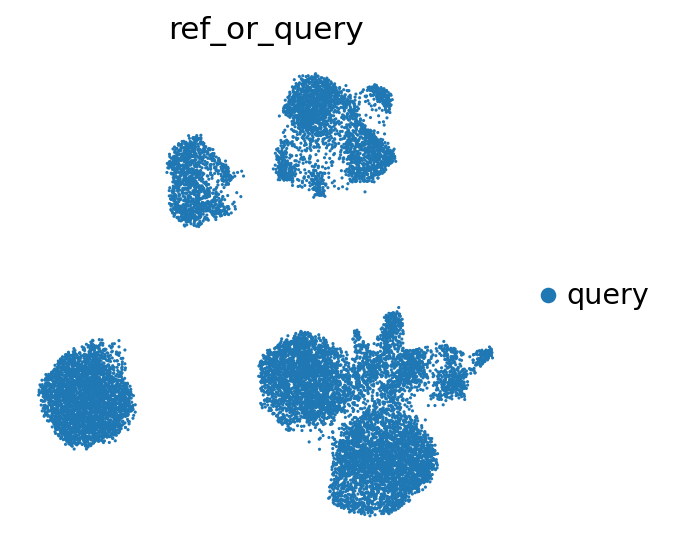

In [49]:
sc.pp.neighbors(adata_query_latent, n_neighbors=30)
sc.tl.umap(adata_query_latent)
sc.pl.umap(
        adata_query_latent,
        color='ref_or_query',
        frameon=False,
        wspace=0.6
        )

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


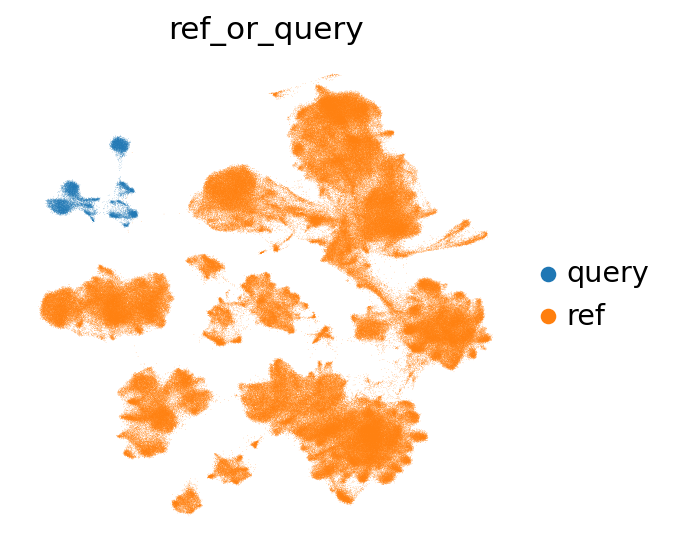

In [36]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)
sc.pl.umap(
        combined_emb,
        color='ref_or_query',
        frameon=False,
        wspace=0.6
        )

#### UMAP Uncertainties

Here we show label transfer uncertainties per level. Regions with high uncertainty can highlight interesting cell types/states, not present in the reference. Note that uncertainties will get higher, the more detailed we go:

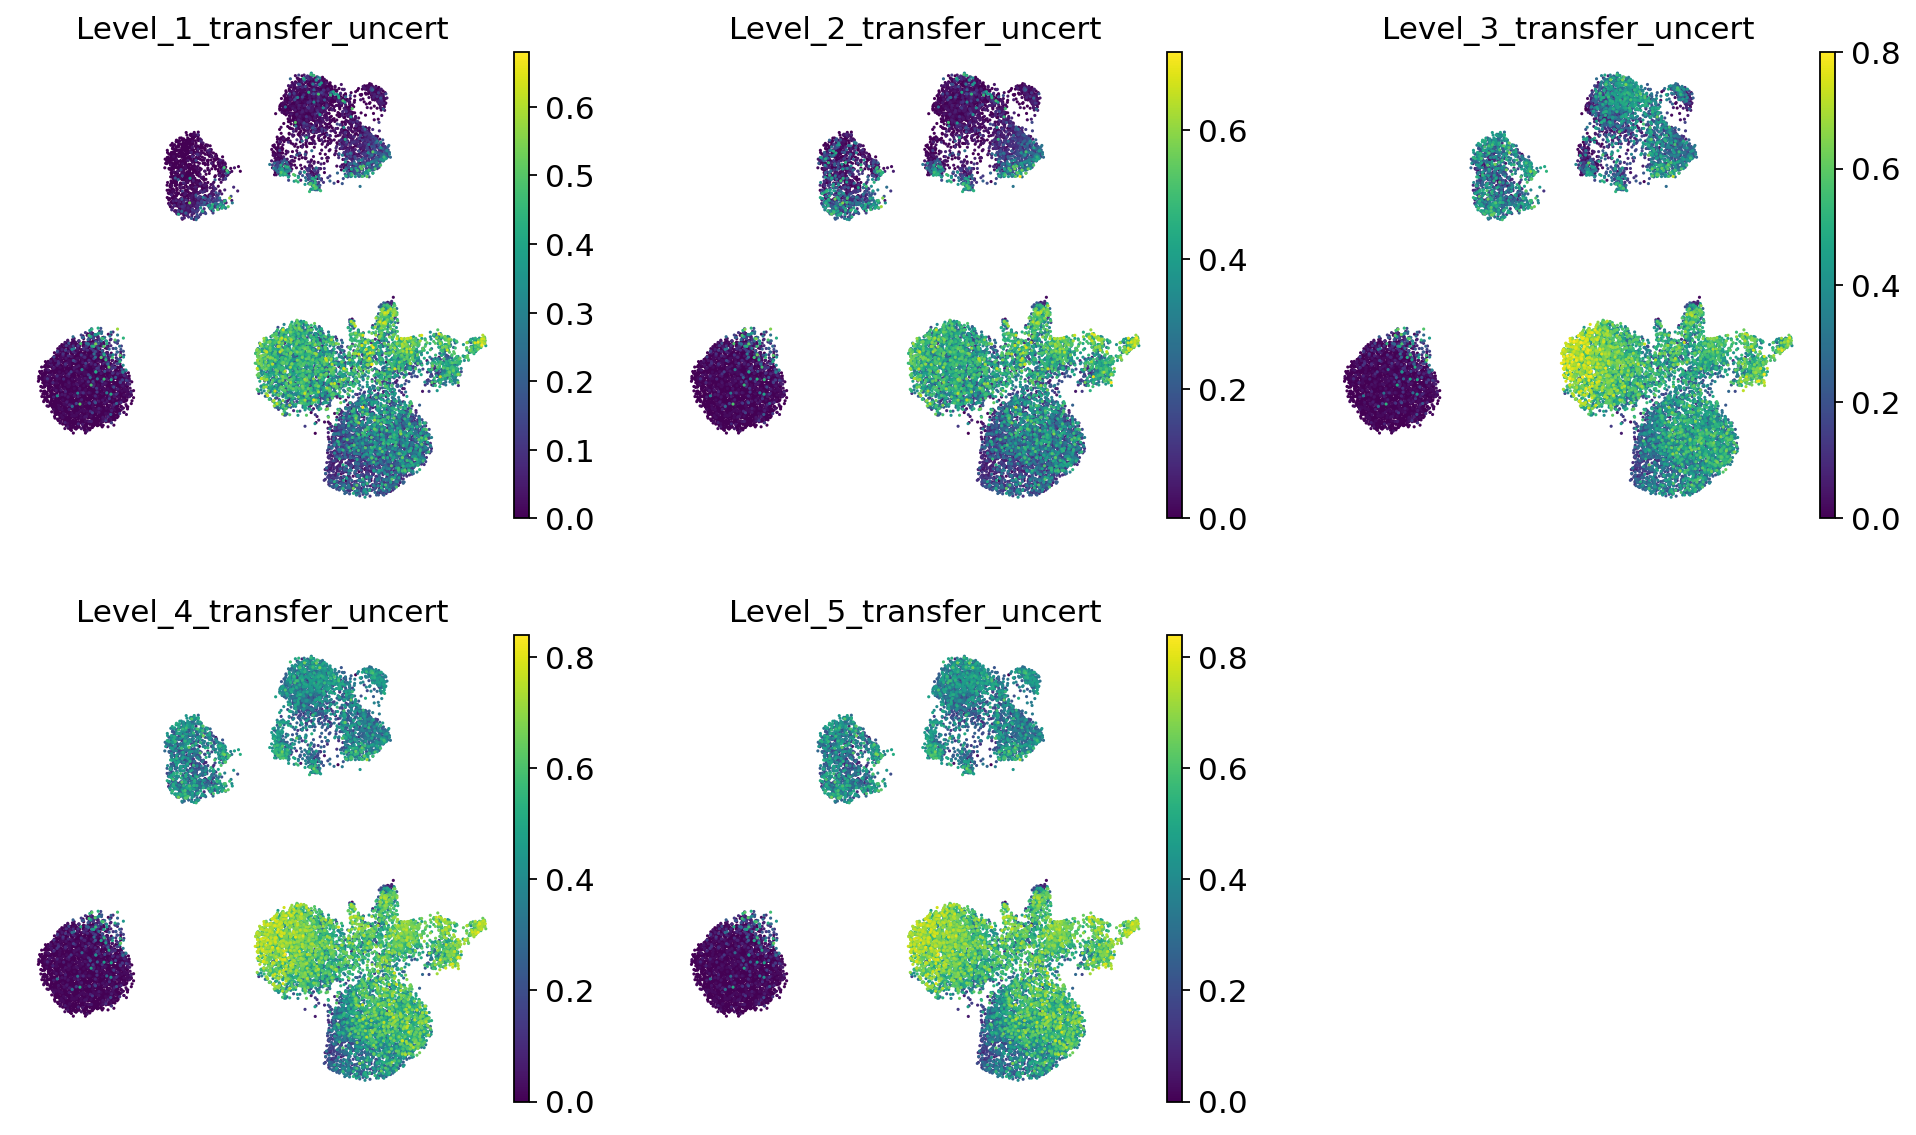

In [78]:
sc.pl.umap(
    adata_query_latent,
    color=[f'Level_{lev}_transfer_uncert' for lev in range(1,6)],
    ncols=3,
    frameon=False,
    )

In [ ]:
met

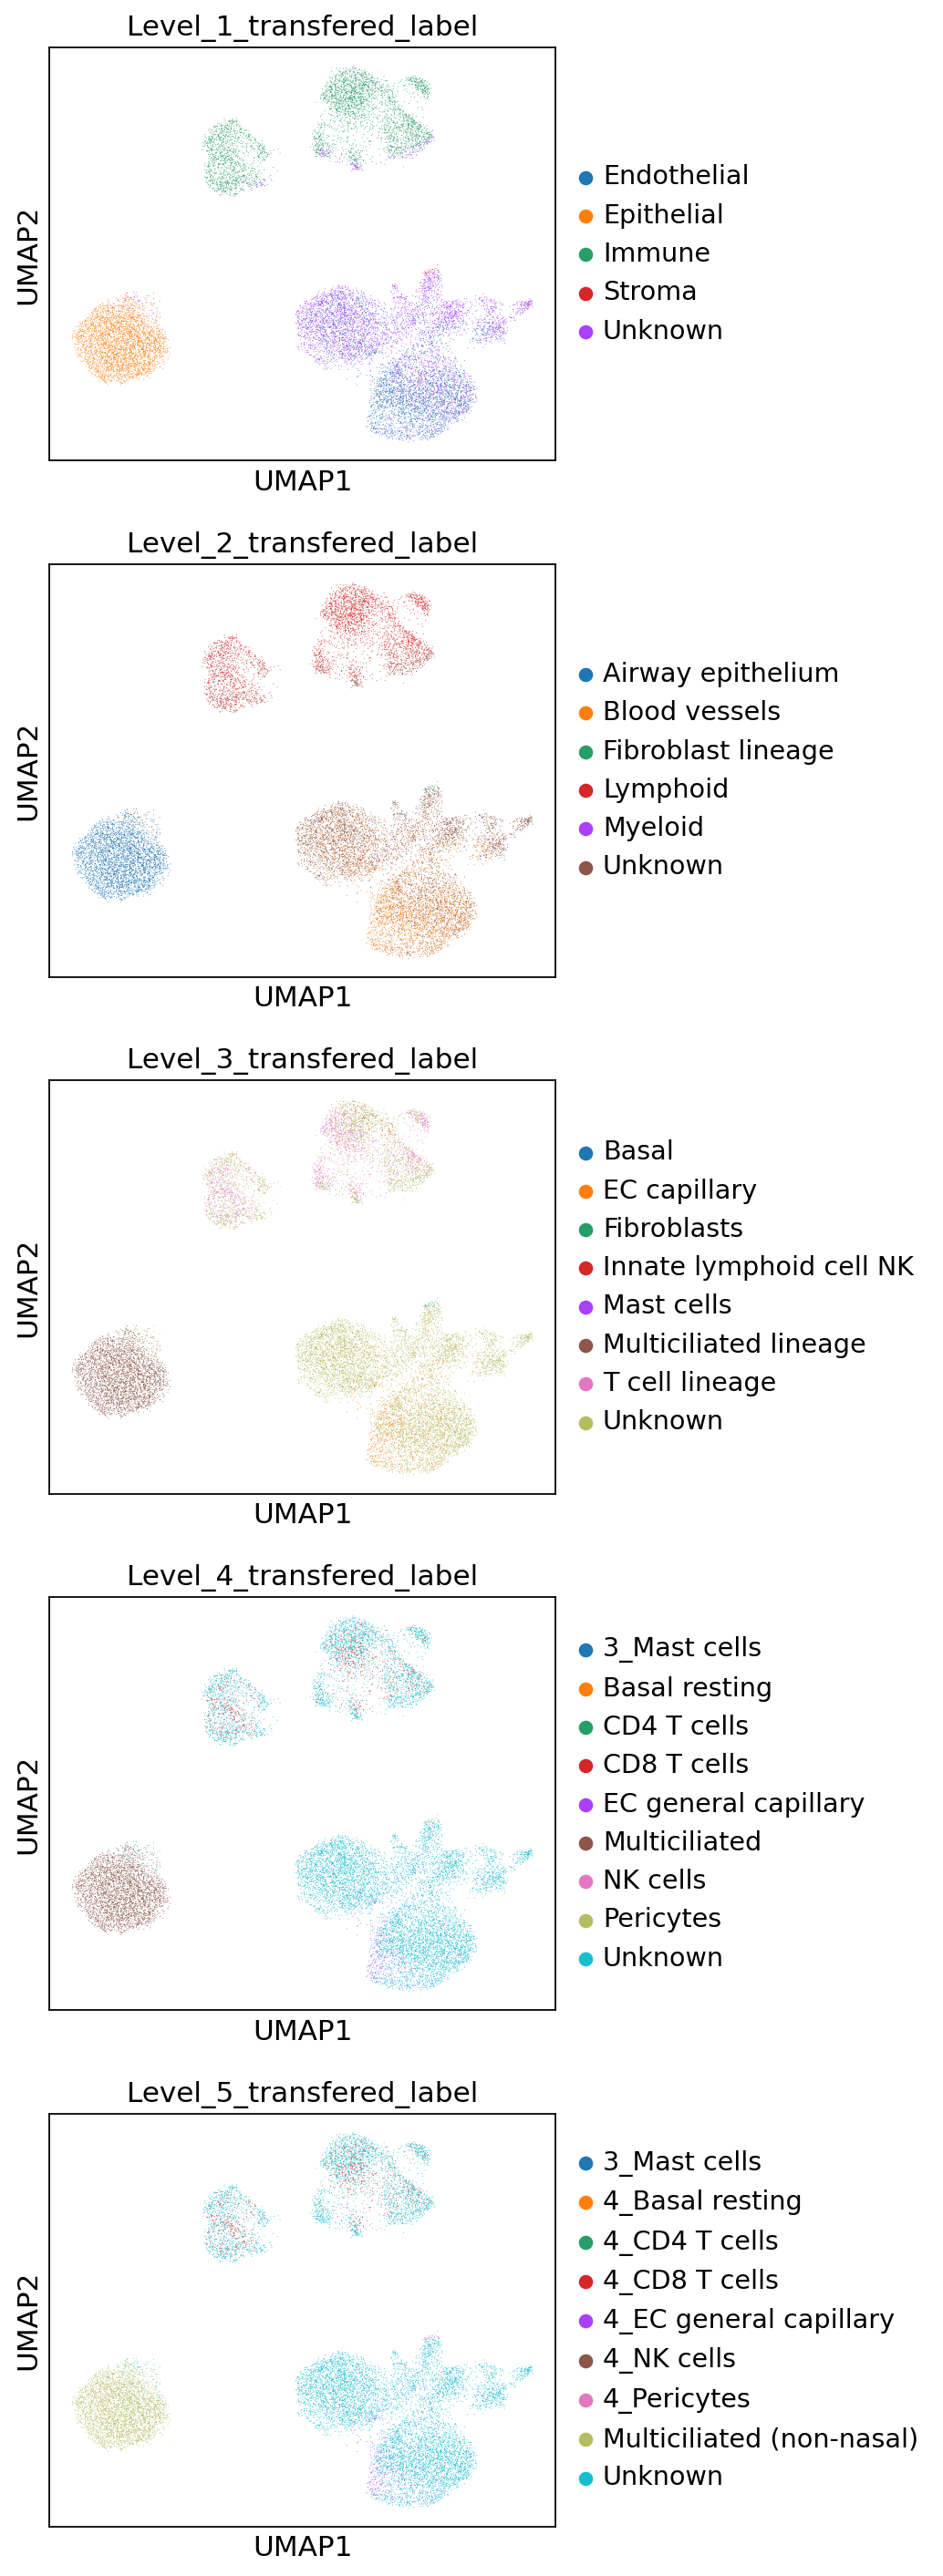

In [75]:
sc.pl.umap(
        adata_query_latent,
        color=[f"Level_{lev}_transfered_label" for lev in range(1,6)],
        na_color="grey",
        ncols=1,
        size=0.7
)